From Trello: \
Measure flux and noise using photutils.aperture.CircularAperture. Flux from img, noise from std (sum of square of pixel values within aperture, then sqrt result).
1. do so for D = 30 arcsec aperture radius
2. do so for D = 15 arcsec aperture radius

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture
import os

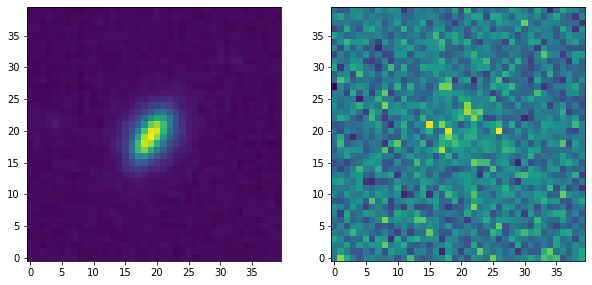

In [2]:
#three test galaxies (trimmed) to call upon here: 0059, 0298, 0323.

#read vf table
homedir = os.getenv("HOME")
vf = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_main.fits')

#define filepaths
filepath_img_0059 = homedir+'/github/VFID0059/unwise-VFID0059-w3-img-m-trim.fits'
filepath_std_0059 = homedir+'/github/VFID0059/unwise-VFID0059-w3-std-m-trim.fits'
filepath_img_0298 = homedir+'/github/VFID0298/unwise-VFID0298-w3-img-m-trim.fits'
filepath_std_0298 = homedir+'/github/VFID0298/unwise-VFID0298-w3-std-m-trim.fits'
filepath_img_0323 = homedir+'/github/VFID0323/unwise-VFID0323-w3-img-m-trim.fits'
filepath_std_0323 = homedir+'/github/VFID0323/unwise-VFID0323-w3-std-m-trim.fits'

#open 0059 and display, because I can.
hdu298_img = fits.open(filepath_img_0298)[0]
hdu298_std = fits.open(filepath_std_0298)[0]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(hdu298_img.data,origin='lower')
ax2.imshow(hdu298_std.data,origin='lower')

In [3]:
#now, to add the circular apertures

#place aperature at center pixel
img_len = len(hdu298_img.data)
position = (img_len/2,img_len/2)

In [4]:
# length (in pixels) multiplied by the transformation matrix: gives length of the cutout in degrees
# multiply by 3600, length of cutout in arcseconds
# (from Adding_WISE_Images_FITS.ipynb --> see www.github.com/Kyssuber, research local branch)
# (negative indicates that axes are flipped, hence the np.abs)

len_arcsec = np.abs(hdu298_img.header['NAXIS1']*hdu298_img.header['CD1_1'])*3600
print(len_arcsec)

110.000000000016


In [5]:
#per pixel, the number of arcseconds is
arcsec_per_pixel = len_arcsec/hdu298_img.header['NAXIS1']
print(arcsec_per_pixel)

2.7500000000004


In [6]:
#thus, for an aperture with a 15 arcsec radius,
radius_15 = 15/arcsec_per_pixel
print('15 arcsec: ',radius_15)
#and for 30 arcsec radius,
radius_30 = 30/arcsec_per_pixel
print('30 arcsec: ',radius_30)

15 arcsec:  5.454545454544661
30 arcsec:  10.909090909089322


(<matplotlib.patches.Circle at 0x7fea94999d30>,)

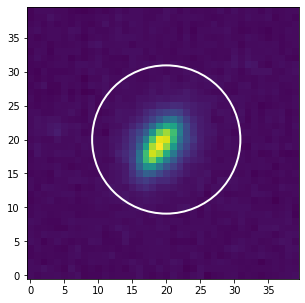

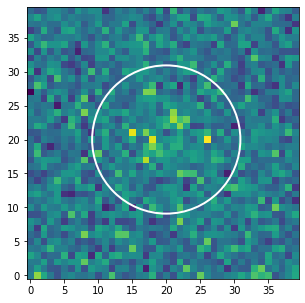

In [12]:
#NOW we add the circular apertures...

aper15 = CircularAperture(position,radius_15)
aper30 = CircularAperture(position,radius_30)

plt.figure(figsize=(5,5))
plt.imshow(hdu298_img.data,origin='lower')
aper30.plot(color='white',lw=2)
plt.figure(figsize=(5,5))
plt.imshow(hdu298_std.data,origin='lower')
aper30.plot(color='white',lw=2)

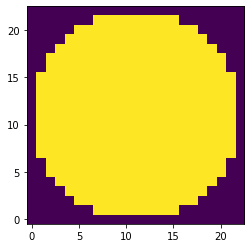

In [8]:
#the following masks pixels within the above aperture. Yellow are "1", purple are "0".
mask30 = aper30.to_mask(method='center')
plt.figure()
plt.imshow(mask30,origin='lower')

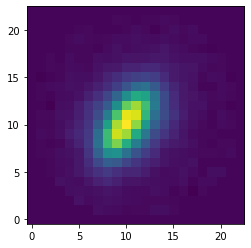

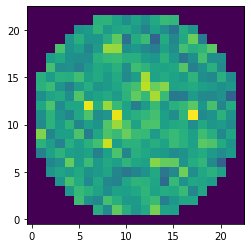

In [9]:
#and THIS yields an array of pixel values for every square contained within this mask
data30_im = mask30.multiply(hdu298_img.data)
data30_std = mask30.multiply(hdu298_std.data)

#plotting,
plt.figure()
plt.imshow(data30_im,origin='lower')
plt.figure()
plt.imshow(data30_std,origin='lower')

In [10]:
#both datasets are numpy arrays, so following the procedure to extract sigma across the encapsulated std 
#pixels is not too tricky.

#isolating every pixel of the above that is >0 (since the 0 is a consequence of the masking and not the image
#itself), creating a 1D array,
data_std = data30_std[data30_std>0]

#sum the square of every element,then calculate the square root...
data_std_sum = np.sum(data_std**2)
noise = np.sqrt(data_std_sum)
print('noise: ','%.2f'%noise)

#to find the 'signal' is, I assume, to use the identical approach...
data_im = data30_im[data30_im>0]
data_im_sum = np.sum(data_im**2)
signal = np.sqrt(data_im_sum)
print('signal: ','%.2f'%signal)

print(' ')
print('snr 30 arcsec:', '%.2f'%(signal/noise))

noise:  7043.59
signal:  174581.05
 
snr 30 arcsec: 24.79


In [13]:
#doing so for tthe 15 arcsec apertures,

mask15 = aper15.to_mask(method='center')

data15_im = mask15.multiply(hdu298_img.data)
data15_std = mask15.multiply(hdu298_std.data)

data_std = data15_std[data15_std>0]

data_std_sum = np.sum(data_std**2)
noise = np.sqrt(data_std_sum)
print('noise: ','%.2f'%noise)

#to find the 'signal' is, I assume, to use the identical approach...
data_im = data15_im[data15_im>0]
data_im_sum = np.sum(data_im**2)
signal = np.sqrt(data_im_sum)
print('signal: ','%.2f'%signal)

print(' ')
print('snr 15 arcsec:', '%.2f'%(signal/noise))

noise:  3881.19
signal:  171798.00
 
snr 15 arcsec: 44.26
